In [3]:
!pip install --upgrade pip

In [4]:
!pip install -r ../requirements.txt

  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached langchain_core-1.0.5-py3-none-any.whl.metadata (3.6 kB)
  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached openai-2.8.0-py3-none-any.whl.metadata (29 kB)
  Using cached sentence_transformers-3.1.1-py3-none-any.whl.metadata (10 kB)
  Using cached transformers-4.45.2-py3-none-any.whl.metadata (44 kB)
  Using cached qdrant_client-1.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached safetensors-0.6.2-cp38-

In [23]:
import sys
print(sys.executable)


c:\Users\Calmen\OneDrive\Desktop\NUS\Y4S1\DSA4213\project_env\Scripts\python.exe


In [19]:
!pip install pywin32==306

   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.2 MB 5.6 MB/s eta 0:00:02
   ---------- ----------------------------- 2.4/9.2 MB 6.4 MB/s eta 0:00:02
   --------------- ------------------------ 3.7/9.2 MB 6.2 MB/s eta 0:00:01
   -------------------- ------------------- 4.7/9.2 MB 6.1 MB/s eta 0:00:01
   -------------------------- ------------- 6.0/9.2 MB 5.9 MB/s eta 0:00:01
   -------------------------------- ------- 7.6/9.2 MB 6.1 MB/s eta 0:00:01
   -------------------------------------- - 8.9/9.2 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 9.2/9.2 MB 6.1 MB/s  0:00:01


In [2]:
os.getcwd()

'c:\\Users\\Calmen\\OneDrive\\Desktop\\NUS\\Y4S1\\DSA4213\\DSA4213-SEC-Fillings-Chatbot\\notebooks'

In [3]:
######################################################################
#      SEC 10-Q RAG — CLEAN SELF-CONTAINED EVALUATION
#   (Query-only extraction from Base RAG + Full Pipeline RAG)
######################################################################

import os
import re
import json
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from qdrant_client import QdrantClient, models
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from sentence_transformers import CrossEncoder
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
load_dotenv()

######################################################################
# CONFIG
######################################################################

QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
COLLECTION = "sec_filings_10q_GOLDEN_BENCHMARK"

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
LLM_MODEL = "gpt-4o"
CROSS_ENCODER_MODEL = "cross-encoder/ms-marco-MiniLM-L-6-v2"


######################################################################
# BASE RAG — Query-Only Extract
######################################################################

class BaseRAG:
    def __init__(self):
        self.client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)
        self.embedder = SentenceTransformer(EMB_MODEL)
        self.llm = ChatOpenAI(model=LLM_MODEL, api_key=OPENAI_API_KEY)

        self.prompt = ChatPromptTemplate.from_template(
        """You are a financial analyst. Answer based ONLY on the provided context.

<context>
{context}
</context>

Question: {input}

Answer:""")

    def _search(self, question):
        v = self.embedder.encode(question).tolist()
        results = self.client.search(
            collection_name=COLLECTION,
            query_vector=v,
            limit=5,
            with_payload=True
        )
        return results

    def _format_ctx(self, results):
        out=[]
        for i,r in enumerate(results,1):
            payload=r.payload
            out.append(f"Source {i} ({payload['ticker']} - {payload['item']}):\n\"{payload['text']}\"\n")
        return "\n".join(out)

    def query(self, question):
        hits = self._search(question)
        ctx = self._format_ctx(hits)

        prompt_msg = self.prompt.format_messages(context=ctx, input=question)
        ans = self.llm.invoke(prompt_msg).content

        return ans


######################################################################
# FULL PIPELINE RAG — Query-Only Extract (NER removed)
######################################################################

class FullPipelineRAG:
    def __init__(self):
        self.client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)
        self.embedder = SentenceTransformer(EMB_MODEL)
        self.reranker = CrossEncoder(CROSS_ENCODER_MODEL)
        self.llm = ChatOpenAI(model=LLM_MODEL, api_key=OPENAI_API_KEY)

        self.prompt = ChatPromptTemplate.from_template(
        """You are a financial analyst. Answer based ONLY on the provided context.

<context>
{context}
</context>

Question: {input}

Answer:""")

    def _retrieve(self, question):
        v = self.embedder.encode(question).tolist()
        hits = self.client.search(
            collection_name=COLLECTION,
            query_vector=v,
            limit=20,
            with_payload=True
        )
        return hits

    def _rerank(self, question, hits):
        passages=[h.payload["text"] for h in hits]
        pairs=[(question,p) for p in passages]
        scores=self.reranker.predict(pairs)

        ranked=[]
        for s,h in zip(scores,hits):
            ranked.append((float(s),h))
        ranked.sort(key=lambda x: -x[0])
        return [h for s,h in ranked[:5]]

    def _format_ctx(self, hits):
        out=[]
        for i,h in enumerate(hits,1):
            p=h.payload
            out.append(f"Source {i} ({p['ticker']} - {p['item']}):\n\"{p['text']}\"\n")
        return "\n".join(out)

    def query(self, question):
        hits = self._retrieve(question)
        hits = self._rerank(question, hits)
        ctx = self._format_ctx(hits)

        prompt_msg=self.prompt.format_messages(context=ctx,input=question)
        ans=self.llm.invoke(prompt_msg).content
        return ans


######################################################################
# INSTANTIATE BOTH MODELS
######################################################################

base = BaseRAG()
full = FullPipelineRAG()

######################################################################
# LOAD GROUND TRUTH
######################################################################

df = pd.read_csv("data/SEC QnA.csv")
df.columns=[c.lower() for c in df.columns]
df=df[["question","answer"]].dropna().reset_index(drop=True)

######################################################################
# SEMANTIC + NUMERIC METRICS
######################################################################

eval_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
num_pat = re.compile(r"[-+]?\d*\.\d+|\d+")

def sim(a,b):
    if not a or not b: return 0
    ea=eval_model.encode(a,convert_to_tensor=True)
    eb=eval_model.encode(b,convert_to_tensor=True)
    return float(util.cos_sim(ea,eb)[0][0])

def extract_nums(t):
    return set(num_pat.findall(str(t)))

def num_eval(gt,pred):
    g = extract_nums(gt)
    p = extract_nums(pred)
    return len(g&p), len(g-p), len(p-g)

######################################################################
# EVALUATION LOOP
######################################################################

records=[]

for i,row in tqdm(df.iterrows(), total=len(df)):
    q=row["question"]
    gt=row["answer"]

    try: b = base.query(q)
    except: b=""

    try: f = full.query(q)
    except: f=""

    sb=sim(gt,b)
    sf=sim(gt,f)

    cb,mb,hb=num_eval(gt,b)
    cf,mf,hf=num_eval(gt,f)

    records.append({
        "question": q,
        "gt": gt,
        "base_answer": b,
        "full_answer": f,
        "sim_base": sb,
        "sim_full": sf,
        "base_correct": cb,
        "base_missed": mb,
        "base_hallucinated": hb,
        "full_correct": cf,
        "full_missed": mf,
        "full_hallucinated": hf
    })

df_eval=pd.DataFrame(records)
df_eval.to_csv("evaluation_results.csv",index=False)
df_eval.head()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\Calmen\OneDrive\Desktop\NUS\Y4S1\DSA4213\project_env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Calmen\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

100%|██████████| 125/125 [10:51<00:00,  5.22s/it]


,question,gt,base_answer,full_answer,sim_base,sim_full,base_correct,base_missed,base_hallucinated,full_correct,full_missed,full_hallucinated
0,What was Nvidia's total GAAP revenue for the s...,"$46,743 million (or $46.743 billion).",The provided context does not contain informat...,The provided context does not give information...,0.268479,0.278691,0,3,1,0,3,2
1,How much revenue did the Data Center segment g...,"$41.1 billion, which was a 56% Y/Y increase.",The Data Center segment generated $3.2 billion...,"In Q2 FY26, the Data Center segment for AMD ge...",0.563590,0.506911,0,2,5,0,2,6
2,What was the reported GAAP net income for Q2 F...,"$26,422 million (or $26.422 billion).",The provided context does not contain specific...,The provided context does not give information...,0.256058,0.307497,1,2,1,1,2,1
3,What was the non-GAAP diluted earnings per sha...,$1.05.,The provided context does not include informat...,The provided context does not contain informat...,0.255822,0.132167,0,1,1,0,1,1
4,How much capital did Nvidia return to sharehol...,$24.3 billion.,"In the first half of fiscal year 2026, Nvidia ...","In the first half of fiscal year 2026, NVIDIA ...",0.359619,0.337717,0,1,2,0,1,3


In [5]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.1 MB 8.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.4/8.1 MB 8.8 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 8.2 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 8.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 8.0 MB/s  0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   --------------------------- ------------ 1.6/2.3 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 7.1 MB/s  0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- ---------------------

,0
Mean Semantic Similarity (Base),0.461340
Mean Semantic Similarity (Full),0.461091
Correct Numbers (Base),0.112000
Correct Numbers (Full),0.144000
Missed Numbers (Base),1.480000
Missed Numbers (Full),1.448000
Hallucinated Numbers (Base),1.672000
Hallucinated Numbers (Full),1.824000


Saved: semantic_similarity_boxplot.png


C:\Users\Calmen\AppData\Local\Temp\ipykernel_29672\1733418763.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["sim_base"], df["sim_full"]], labels=["Base RAG", "Full Pipeline"])


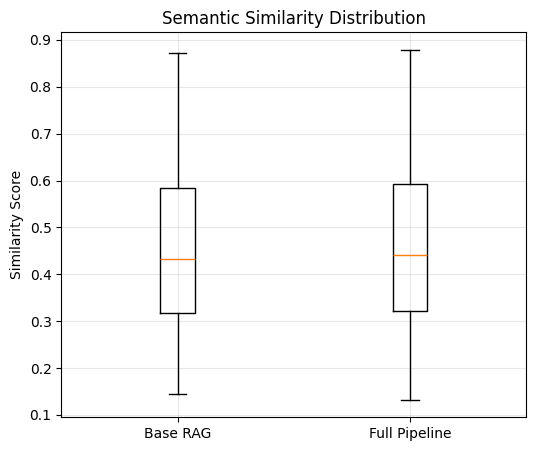

Saved: correct_numbers_boxplot.png


C:\Users\Calmen\AppData\Local\Temp\ipykernel_29672\1733418763.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["base_correct"], df["full_correct"]], labels=["Base RAG", "Full Pipeline"])


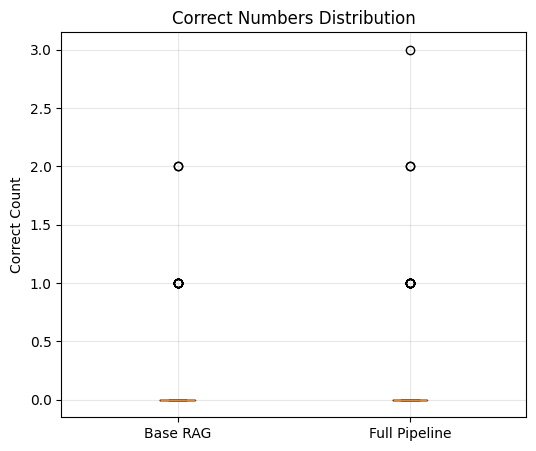

C:\Users\Calmen\AppData\Local\Temp\ipykernel_29672\1733418763.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["base_missed"], df["full_missed"]], labels=["Base RAG", "Full Pipeline"])


Saved: missed_numbers_boxplot.png


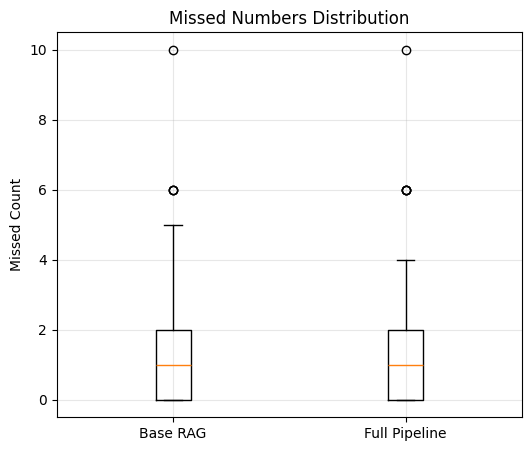

C:\Users\Calmen\AppData\Local\Temp\ipykernel_29672\1733418763.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["base_hallucinated"], df["full_hallucinated"]], labels=["Base RAG", "Full Pipeline"])


Saved: hallucinated_numbers_boxplot.png


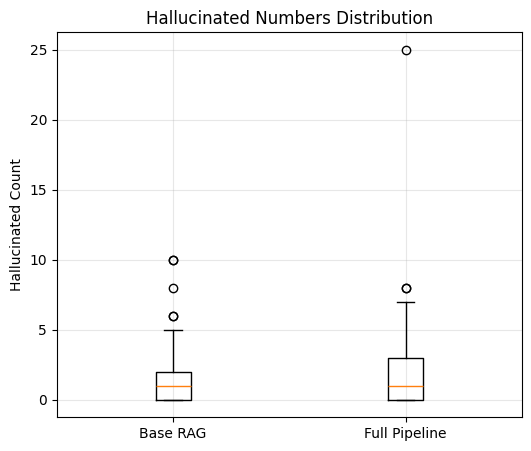

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load evaluation results
df = pd.read_csv("evaluation_results.csv")

# -----------------------------
# SUMMARY STATISTICS
# -----------------------------
summary = {
    "Mean Semantic Similarity (Base)": df["sim_base"].mean(),
    "Mean Semantic Similarity (Full)": df["sim_full"].mean(),
    "Correct Numbers (Base)": df["base_correct"].mean(),
    "Correct Numbers (Full)": df["full_correct"].mean(),
    "Missed Numbers (Base)": df["base_missed"].mean(),
    "Missed Numbers (Full)": df["full_missed"].mean(),
    "Hallucinated Numbers (Base)": df["base_hallucinated"].mean(),
    "Hallucinated Numbers (Full)": df["full_hallucinated"].mean(),
}

display(pd.DataFrame(summary, index=[0]).T)

# -----------------------------
# HELPER FUNCTION TO SAVE PLOT
# -----------------------------
def save_plot(filename):
    plt.savefig(filename, dpi=150, bbox_inches="tight")
    print(f"Saved: {filename}")

# -----------------------------
# PLOT 1: Semantic Similarity
# -----------------------------
plt.figure(figsize=(6,5))
plt.boxplot([df["sim_base"], df["sim_full"]], labels=["Base RAG", "Full Pipeline"])
plt.title("Semantic Similarity Distribution")
plt.ylabel("Similarity Score")
plt.grid(alpha=0.3)
save_plot("semantic_similarity_boxplot.png")
plt.show()

# -----------------------------
# PLOT 2: Correct Numbers
# -----------------------------
plt.figure(figsize=(6,5))
plt.boxplot([df["base_correct"], df["full_correct"]], labels=["Base RAG", "Full Pipeline"])
plt.title("Correct Numbers Distribution")
plt.ylabel("Correct Count")
plt.grid(alpha=0.3)
save_plot("correct_numbers_boxplot.png")
plt.show()

# -----------------------------
# PLOT 3: Missed Numbers
# -----------------------------
plt.figure(figsize=(6,5))
plt.boxplot([df["base_missed"], df["full_missed"]], labels=["Base RAG", "Full Pipeline"])
plt.title("Missed Numbers Distribution")
plt.ylabel("Missed Count")
plt.grid(alpha=0.3)
save_plot("missed_numbers_boxplot.png")
plt.show()

# -----------------------------
# PLOT 4: Hallucinated Numbers
# -----------------------------
plt.figure(figsize=(6,5))
plt.boxplot([df["base_hallucinated"], df["full_hallucinated"]], labels=["Base RAG", "Full Pipeline"])
plt.title("Hallucinated Numbers Distribution")
plt.ylabel("Hallucinated Count")
plt.grid(alpha=0.3)
save_plot("hallucinated_numbers_boxplot.png")
plt.show()

# -----------------------------
# OPTIONAL: BAR CHART SUMMARY
# --------------


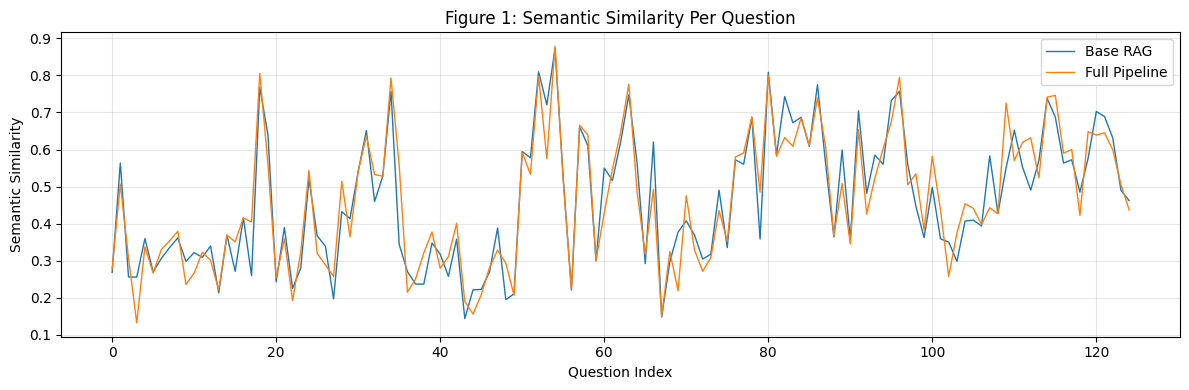

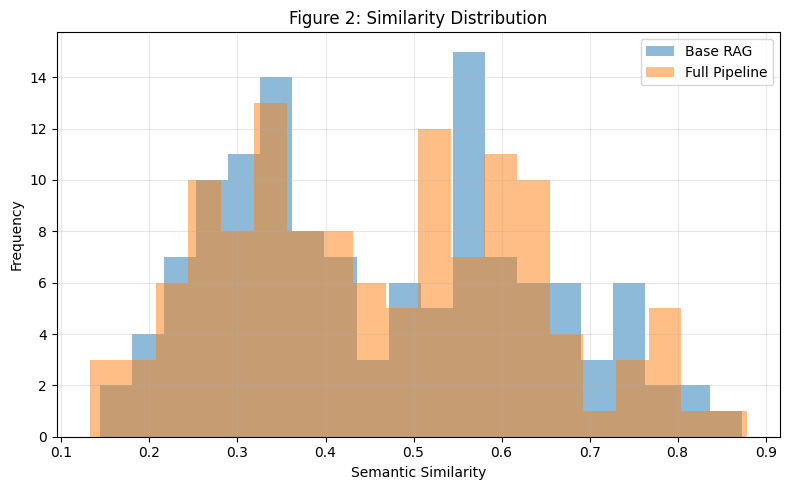

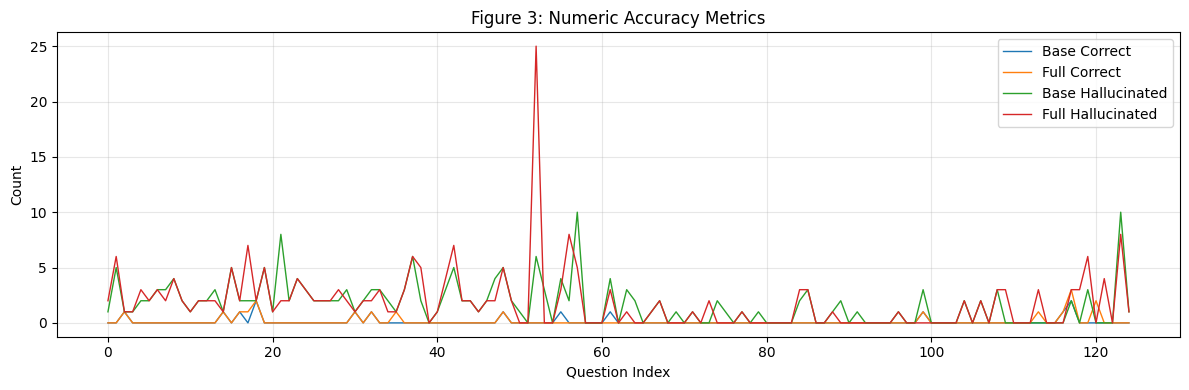

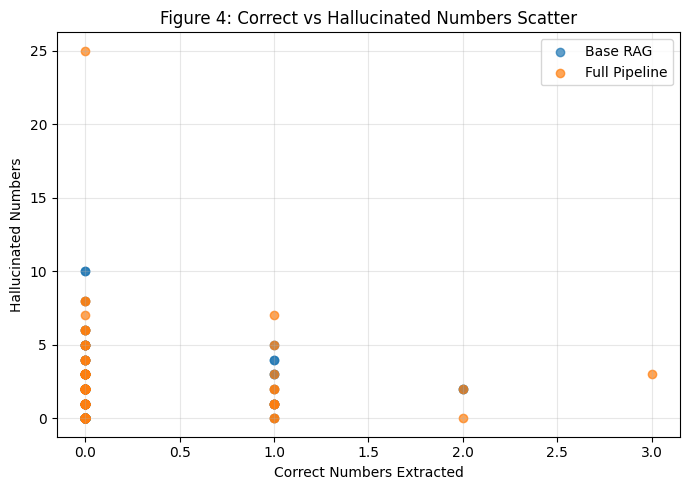

In [7]:
# ---------------------------------------------------------
# Figure 1: Semantic Similarity Per Question
# ---------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(df['sim_base'], label='Base RAG', linewidth=1)
plt.plot(df['sim_full'], label='Full Pipeline', linewidth=1)
plt.legend()
plt.title("Figure 1: Semantic Similarity Per Question")
plt.xlabel("Question Index")
plt.ylabel("Semantic Similarity")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Figure 2: Similarity Distribution Histogram
# ---------------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(df['sim_base'], alpha=0.5, label='Base RAG', bins=20)
plt.hist(df['sim_full'], alpha=0.5, label='Full Pipeline', bins=20)
plt.legend()
plt.title("Figure 2: Similarity Distribution")
plt.xlabel("Semantic Similarity")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Figure 3: Numeric Metrics (Correct / Hallucinated / Missed)
# ---------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(df['base_correct'], label='Base Correct', linewidth=1)
plt.plot(df['full_correct'], label='Full Correct', linewidth=1)
plt.plot(df['base_hallucinated'], label='Base Hallucinated', linewidth=1)
plt.plot(df['full_hallucinated'], label='Full Hallucinated', linewidth=1)
plt.legend()
plt.title("Figure 3: Numeric Accuracy Metrics")
plt.xlabel("Question Index")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Figure 4: Scatter Plot of Correct vs. Hallucinated Numbers
# ---------------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(df['base_correct'], df['base_hallucinated'], label='Base RAG', alpha=0.7)
plt.scatter(df['full_correct'], df['full_hallucinated'], label='Full Pipeline', alpha=0.7)
plt.legend()
plt.title("Figure 4: Correct vs Hallucinated Numbers Scatter")
plt.xlabel("Correct Numbers Extracted")
plt.ylabel("Hallucinated Numbers")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
